# 4. How to select All in all one model

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt

# Load the diabetes dataset from UCI repository
df = pd.read_csv("/kaggle/input/diabete/diabetes.csv")

# Display the first few rows to verify the data
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [2]:
# Assuming the last column is the target variable and all others are features
X = df.iloc[:, :-1]  # All columns except the last one
y = df.iloc[:, -1]   # Last column as the target

print("Shape of X:", X.shape)  # Should be (768, 8) if using the diabetes dataset
print("Shape of y:", y.shape)  # Should be (768,)


Shape of X: (768, 8)
Shape of y: (768,)


In [3]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X= scale.fit_transform(X)

In [4]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)  # Should be (614, 8)
print("Shape of X_test:", X_test.shape)    # Should be (154, 8)


Shape of X_train: (537, 8)
Shape of X_test: (231, 8)


In [6]:
def build_model(hp):
    # Initialize the Sequential model
    model = Sequential()
    counter = 0

    # Loop through the number of layers specified by the hyperparameters
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
        # Add the first layer with input dimension
        if counter == 0:
            model.add(Dense(
                units=hp.Int('units_' + str(i), min_value=8, max_value=128, step=8),
                activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid']),
                input_dim=8  # Input dimension for the first layer
            ))
        else:
            # Add hidden layers
            model.add(Dense(
                units=hp.Int('units_' + str(i), min_value=8, max_value=128, step=8),
                activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])
            ))
        counter += 1

    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd', 'nadam', 'adadelta']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [8]:
tuner1 = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5
)

tuner1.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))




Trial 5 Complete [00h 00m 03s]
val_accuracy: 0.7316017150878906

Best val_accuracy So Far: 0.7316017150878906
Total elapsed time: 00h 00m 21s


In [9]:
tuner1.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
num_layers: 3
units_0: 128
activation_0: tanh
optimizer: nadam
units_1: 16
activation_1: relu
units_2: 48
activation_2: tanh
units_3: 24
activation_3: relu
units_4: 48
activation_4: relu
units_5: 80
activation_5: sigmoid
units_6: 64
activation_6: sigmoid
units_7: 80
activation_7: relu
units_8: 88
activation_8: relu
Score: 0.7316017150878906

Trial 0 summary
Hyperparameters:
num_layers: 9
units_0: 104
activation_0: tanh
optimizer: adam
units_1: 8
activation_1: relu
units_2: 8
activation_2: relu
units_3: 8
activation_3: relu
units_4: 8
activation_4: relu
units_5: 8
activation_5: relu
units_6: 8
activation_6: relu
units_7: 8
activation_7: relu
units_8: 8
activation_8: relu
Score: 0.709956705570221

Trial 1 summary
Hyperparameters:
num_layers: 1
units_0: 40
activation_0: relu
optimizer: nadam
units_1: 56
activation_1: tanh
units_2: 56
activa

In [10]:
tuner1 .get_best_hyperparameters()[0].values

{'num_layers': 3,
 'units_0': 128,
 'activation_0': 'tanh',
 'optimizer': 'nadam',
 'units_1': 16,
 'activation_1': 'relu',
 'units_2': 48,
 'activation_2': 'tanh',
 'units_3': 24,
 'activation_3': 'relu',
 'units_4': 48,
 'activation_4': 'relu',
 'units_5': 80,
 'activation_5': 'sigmoid',
 'units_6': 64,
 'activation_6': 'sigmoid',
 'units_7': 80,
 'activation_7': 'relu',
 'units_8': 88,
 'activation_8': 'relu'}

In [11]:
# Get the best model
model1 = tuner1.get_best_models(num_models=1)[0]

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 19 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
history = model1.fit(X_train, y_train, batch_size=32, epochs=100, initial_epoch=6,validation_data=(X_test, y_test))

Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7913 - loss: 0.4258 - val_accuracy: 0.7446 - val_loss: 0.5100
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7895 - loss: 0.4243 - val_accuracy: 0.7489 - val_loss: 0.5116
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7674 - loss: 0.4563 - val_accuracy: 0.7403 - val_loss: 0.5166
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7848 - loss: 0.4593 - val_accuracy: 0.7403 - val_loss: 0.5201
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8003 - loss: 0.4122 - val_accuracy: 0.7532 - val_loss: 0.5231
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7841 - loss: 0.4570 - val_accuracy: 0.7489 - val_loss: 0.5242
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8058 - loss: 0.4110 - val_accuracy: 0.7489 - val_loss: 0.5274
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7960 - loss: 0.4164 - val_accuracy: 0.74

### Accuracy of Model

In [13]:
loss,accuracy = model1.evaluate(X_test,y_test)
print("Accuracy of model:- ",accuracy*100)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7427 - loss: 0.6280 
Accuracy of model:-  71.86146974563599


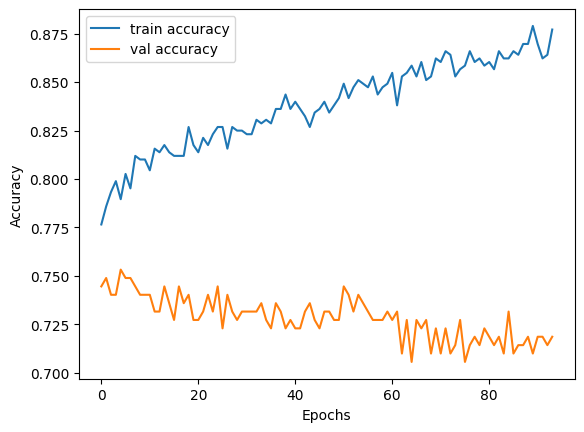

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
